In [47]:
# === Imports (notebook) ===
import os
from pathlib import Path

import math
import tqdm # do pasków postępu
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from PIL import Image # do obsługi obrazów

# wykresy – używaj tylko gdy faktycznie rysujesz
import matplotlib.pyplot as plt
# import seaborn as sns  # odkomentuj tylko jeśli używasz

# cuda – info diagnostyczne
print("PyTorch:", torch.__version__, "| CUDA:", torch.version.cuda, "| Liczba GPU:", torch.cuda.device_count(), "| Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

PyTorch: 2.8.0+cu129 | CUDA: 12.9 | Liczba GPU: 1 | Nazwa GPU: NVIDIA GeForce RTX 3090


In [10]:
# === Paths ===
DATASET_DIR = Path(r"C:\Datasets\koniq10k\512x384")
FRAMES_DIR  = Path(r"D:\Programowanie\Python\Projects\drone-quality-assessment\data\frames")
RESULTS_DIR = Path(r"D:\Programowanie\Python\Projects\drone-quality-assessment\results")
CSV_LABELS = Path(r"C:\Datasets\koniq10k\koniq10k_distributions_sets.csv")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Dataset:", DATASET_DIR)
print("Frames :", FRAMES_DIR)
print("Results:", RESULTS_DIR)
print("Labels :", CSV_LABELS)

Dataset: C:\Datasets\koniq10k\512x384
Frames : D:\Programowanie\Python\Projects\drone-quality-assessment\data\frames
Results: D:\Programowanie\Python\Projects\drone-quality-assessment\results
Labels : C:\Datasets\koniq10k\koniq10k_distributions_sets.csv


In [18]:
# === Sanity check ===
assert DATASET_DIR.exists(), f"Brak katalogu datasetu: {DATASET_DIR}"
assert FRAMES_DIR.exists(),  f"Brak katalogu klatek: {FRAMES_DIR}"
assert CSV_LABELS.exists(), f"Brak etykiet: {CSV_LABELS}"

# Podgląd kilku plików
from itertools import islice
sample_frames = list(islice((p for p in FRAMES_DIR.glob("*.jpg")), 5))
print("Przykładowe klatki:", [p.name for p in sample_frames])

# Szybkie liczniki
def count_images(p: Path):
    return sum(1 for _ in p.rglob("*.jpg")) + sum(1 for _ in p.rglob("*.png"))
print("Liczba obrazów w dataset:", count_images(DATASET_DIR))
print("Liczba klatek do inferencji:", count_images(FRAMES_DIR))
df_labels = pd.read_csv(CSV_LABELS)
df_labels.head()

Przykładowe klatki: ['frame_0001__q4_s1_e2_k3__brisque13.jpg', 'frame_0002__q2_s4_e4_k5__brisque13.jpg', 'frame_0003__q5_s3_e5_k5__brisque15.jpg', 'frame_0004__q3_s2_e3_k4__brisque14.jpg', 'frame_0005__q1_s5_e1_k1__brisque15.jpg']
Liczba obrazów w dataset: 10373
Liczba klatek do inferencji: 8


,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,set
0,10004473376.jpg,0.000000,0.00000,0.238095,0.695238,0.066667,105,77.383621,0.527278,training
1,10007357496.jpg,0.000000,0.03125,0.468750,0.489583,0.010417,96,68.728571,0.580003,test
2,10007903636.jpg,0.010417,0.00000,0.208333,0.760417,0.020833,96,78.628571,0.527220,training
3,10009096245.jpg,0.000000,0.00000,0.192661,0.688073,0.119266,109,77.243750,0.556218,training
4,100117038.jpg,0.000000,0.01000,0.210000,0.720000,0.060000,100,75.112500,0.532860,training


In [19]:
IM_SIZE = 224  # standardowy rozmiar dla ResNet

transform_eval = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),   # skalujemy do stałego rozmiaru
    transforms.ToTensor(),                   # [H,W,C] uint8 → [C,H,W] float32 w [0,1]
    transforms.Normalize(                    # normalizacja jak w ImageNet (trening ResNet)
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])
print("Transform ready.")

Transform ready.


In [26]:
class FramesFolder(Dataset):
    def __init__(self, root: Path, transform=None, patterns=("*.jpg","*.png","*.jpeg")):
        self.paths = []
        for pat in patterns:
            self.paths += list(root.glob(pat))
        self.paths = sorted(self.paths)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")  # zawsze 3 kanały
        if self.transform:
            img = self.transform(img)
        return img, p.name                  # zwracamy tensora i nazwę pliku

frames_ds = FramesFolder(FRAMES_DIR, transform=transform_eval)

# batch_size 8 jest OK na RTX 3090, ale jak zobaczysz, że VRAM jest luzem, podniesiemy
frames_loader = DataLoader(
    frames_ds,
    batch_size=8,
    shuffle=False,
    num_workers=0,       # najważniejsza zmiana
    pin_memory=True,    # żeby nie mieszać na razie
    persistent_workers=False
)

print(f"Klatki w loaderze: {len(frames_ds)}")


Klatki w loaderze: 8


In [27]:
imgs, names = next(iter(frames_loader))
print("Kształt batcha:", imgs.shape)  # [B, 3, 224, 224]
print("Przykładowe nazwy:", names[:3])


Kształt batcha: torch.Size([8, 3, 224, 224])
Przykładowe nazwy: ['frame_0001__q4_s1_e2_k3__brisque13.jpg', 'frame_0002__q2_s4_e4_k5__brisque13.jpg', 'frame_0003__q5_s3_e5_k5__brisque15.jpg']


In [30]:
PROJECT_ROOT = Path(r"D:\Programowanie\Python\Projects\drone-quality-assessment")
os.chdir(PROJECT_ROOT)
print("Nowy CWD:", os.getcwd())

Nowy CWD: D:\Programowanie\Python\Projects\drone-quality-assessment


In [31]:
from model.cnn_model import MultiHeadCNN

# liczba klas/wyjść musi pasować do Twojego modelu
num_classes = 5  # placeholder, za chwilę dopasujemy do metryk KonIQ

model = MultiHeadCNN(num_classes=num_classes)
model = model.cuda()  # przenosimy na kartę graficzną
model.eval()          # tryb inferencji (bez dropout, bez gradów)

print("Model gotowy na GPU.")

d:\Programowanie\Python\Envs\ml-pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programowanie\Python\Envs\ml-pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\kbron/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


Model gotowy na GPU.


In [32]:
num_classes = 5
model = MultiHeadCNN(num_classes=num_classes).cuda()
model.eval()

with torch.inference_mode():
    batch_imgs, batch_names = next(iter(frames_loader))
    preds = model(batch_imgs.cuda())

for head, logits in preds.items():
    print(head, logits.shape)


ostrosc torch.Size([8, 5])
swiatlo torch.Size([8, 5])
ekspozycja torch.Size([8, 5])
kadr torch.Size([8, 5])


In [33]:
# Podgląd kolumn i typów – bez przelewania wody
print("Kolumny:", list(df_labels.columns))
print()

# Garść statystyk liczbowych (jeśli jest MOS itp.)
display(df_labels.describe(include="all").T.head(12))

# 3 pierwsze wiersze do wglądu
df_labels.head(3)

Kolumny: ['image_name', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_total', 'MOS', 'SD', 'set']



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
image_name,10073,10073,9996001596.jpg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c1,10073.0,NaN,NaN,NaN,0.022814,0.076469,0.0,0.0,0.0,0.009434,0.903846
c2,10073.0,NaN,NaN,NaN,0.165164,0.210293,0.0,0.017241,0.058252,0.254545,0.845455
c3,10073.0,NaN,NaN,NaN,0.455935,0.181751,0.0,0.321101,0.476636,0.603774,0.853846
c4,10073.0,NaN,NaN,NaN,0.339394,0.24579,0.0,0.096154,0.330357,0.557692,0.881818
c5,10073.0,NaN,NaN,NaN,0.016694,0.030151,0.0,0.0,0.0,0.019608,0.36
c_total,10073.0,NaN,NaN,NaN,107.034051,7.986917,93.0,103.0,106.0,109.0,157.0
MOS,10073.0,NaN,NaN,NaN,58.729617,15.432433,3.911765,49.247768,62.354369,70.7125,88.388889
SD,10073.0,NaN,NaN,NaN,0.574666,0.065992,0.29623,0.531602,0.568305,0.61121,1.098218
set,10073,3,training,7058,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,set
0,10004473376.jpg,0.000000,0.00000,0.238095,0.695238,0.066667,105,77.383621,0.527278,training
1,10007357496.jpg,0.000000,0.03125,0.468750,0.489583,0.010417,96,68.728571,0.580003,test
2,10007903636.jpg,0.010417,0.00000,0.208333,0.760417,0.020833,96,78.628571,0.527220,training


In [34]:
# Spróbujmy zidentyfikować kluczowe kolumny
possible_filename_cols = [c for c in df_labels.columns if "file" in c.lower() or "image" in c.lower() or "name" in c.lower()]
possible_mos_cols      = [c for c in df_labels.columns if c.lower() in {"mos", "meanopinion", "mean_opinion_score"}]

print("Kolumna z nazwą pliku (kandydaci):", possible_filename_cols)
print("Kolumna z MOS (kandydaci):", possible_mos_cols)

# Jeśli są kolumny kategoryczne, pokażmy top-5 kategorii i ich liczność
for c in df_labels.columns:
    if df_labels[c].dtype == "object":
        vc = df_labels[c].value_counts().head(5)
        if len(vc) > 1:
            print(f"\n[categorical] {c} → top5:\n{vc}")

Kolumna z nazwą pliku (kandydaci): ['image_name']
Kolumna z MOS (kandydaci): ['MOS']

[categorical] image_name → top5:
image_name
9996001596.jpg     1
10004473376.jpg    1
10007357496.jpg    1
10007903636.jpg    1
10009096245.jpg    1
Name: count, dtype: int64

[categorical] set → top5:
set
training      7058
test          2015
validation    1000
Name: count, dtype: int64


In [35]:
# === KONFIG DANYCH KONIQ (MOS) ===
# Zakładam, że masz już df_labels w pamięci oraz stałą DATASET_DIR (folder z obrazkami)
# Ta komórka tylko wykrywa nazwy kluczowych kolumn i buduje pełne ścieżki do plików.

# 1) wykryj kolumnę z nazwą pliku
fname_col = None
for c in df_labels.columns:
    cl = c.lower()
    if any(k in cl for k in ["file", "image", "img", "name"]):
        fname_col = c
        break
assert fname_col is not None, "Nie znalazłem kolumny z nazwą pliku (np. image_name)."

# 2) wykryj kolumnę z MOS
mos_col = None
for c in df_labels.columns:
    if c.lower() in {"mos", "meanopinion", "mean_opinion_score", "mos_score"}:
        mos_col = c
        break
assert mos_col is not None, "Nie znalazłem kolumny z MOS."

# 3) zbuduj pełną ścieżkę do pliku obrazu
#    Jeśli w CSV są same nazwy (np. 'img1234.jpg'), dokładamy DATASET_DIR
from pathlib import Path

def _fullpath(name: str) -> Path:
    p = Path(name)
    if p.is_absolute():
        return p
    # najczęściej pliki są bezpośrednio w DATASET_DIR lub w jego podkatalogu
    cand1 = DATASET_DIR / name
    if cand1.exists():
        return cand1
    # jeśli dataset ma podfoldery, możesz dopisać tu dodatkowe heurystyki
    return cand1  # zwróć domyślną ścieżkę; ewentualny brak wychwycimy później

df_koniq = df_labels[[fname_col, mos_col]].copy()
df_koniq["fullpath"] = df_koniq[fname_col].astype(str).map(_fullpath)

# szybki sanity-check
print("Kolumny:", fname_col, "⇢", mos_col)
print("Przykładowe ścieżki:", df_koniq["fullpath"].head().tolist()[:3])
print("Zakres MOS:", float(df_koniq[mos_col].min()), "→", float(df_koniq[mos_col].max()))


Kolumny: image_name ⇢ MOS
Przykładowe ścieżki: [WindowsPath('C:/Datasets/koniq10k/512x384/10004473376.jpg'), WindowsPath('C:/Datasets/koniq10k/512x384/10007357496.jpg'), WindowsPath('C:/Datasets/koniq10k/512x384/10007903636.jpg')]
Zakres MOS: 3.91176470588 → 88.3888888889


In [38]:
# === SPLIT train/val/test z CSV (jeśli dostępny) ===
split_col = None
for c in df_labels.columns:
    if c.lower() in {"set", "split", "subset", "partition"}:
        split_col = c
        break

if split_col:
    print("Wykryto kolumnę split:", split_col)
    print(df_labels[split_col].value_counts())
    df_train = df_koniq[df_labels[split_col].str.lower().isin(["train", "training"])].copy()
    df_val   = df_koniq[df_labels[split_col].str.lower().isin(["val","valid","validation"])].copy()
    df_test  = df_koniq[df_labels[split_col].str.lower().isin(["test"])].copy()
else:
    print("Brak kolumny split w CSV — na razie odłóżmy własny podział.")
    # jeśli będzie potrzebny własny split, zrobimy go później (np. strat. po kwantylach MOS)
    # teraz potraktujmy CAŁOŚĆ jako train (tylko na chwilę, do testu pipeline'u):
    df_train, df_val, df_test = df_koniq.copy(), df_koniq.iloc[0:0].copy(), df_koniq.iloc[0:0].copy()

print("Liczności → train/val/test:", len(df_train), len(df_val), len(df_test))


Wykryto kolumnę split: set
set
training      7058
test          2015
validation    1000
Name: count, dtype: int64
Liczności → train/val/test: 7058 1000 2015


In [39]:
# === PyTorch Dataset dla MOS (regresja) ===
class KonIQMOSDataset(Dataset):
    def __init__(self, frame, fname_col, mos_col, transform=None, must_exist=True):
        self.frame = frame.reset_index(drop=True)
        self.fname_col = fname_col
        self.mos_col = mos_col
        self.transform = transform
        self.must_exist = must_exist

        # odfiltruj potencjalnie brakujące pliki
        if self.must_exist:
            ok = self.frame["fullpath"].map(lambda p: Path(p).exists())
            self.frame = self.frame[ok].reset_index(drop=True)

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        path = Path(row["fullpath"])
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        mos = float(row[self.mos_col])  # skala ~0–100 w Twojej wersji
        mos = torch.tensor([mos], dtype=torch.float32)
        return img, mos, path.name

train_ds = KonIQMOSDataset(df_train, fname_col, mos_col, transform=transform_eval, must_exist=True)
val_ds   = KonIQMOSDataset(df_val,   fname_col, mos_col, transform=transform_eval, must_exist=True)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

print("Gotowe: len(train), len(val) =", len(train_ds), len(val_ds))
imgs, mos, names = next(iter(train_loader))
print("Batch kształt:", imgs.shape, "| MOS kształt:", mos.shape, "| Przykładowe nazwy:", names[:3])


Gotowe: len(train), len(val) = 7058 1000
Batch kształt: torch.Size([32, 3, 224, 224]) | MOS kształt: torch.Size([32, 1]) | Przykładowe nazwy: ['8213284057.jpg', '5679420644.jpg', '233045606.jpg']


In [40]:
# === Model: ResNet18 + regresja MOS ===
import torch.nn as nn
import torchvision.models as models

class CNNforMOS(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_features = base.fc.in_features
        base.fc = nn.Identity()
        self.backbone = base
        self.mos = nn.Linear(in_features, 1)  # jedna wartość: MOS

    def forward(self, x):
        feats = self.backbone(x)
        mos  = self.mos(feats)
        return mos


In [41]:
# === Przygotowanie modelu i parametrów treningu ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNforMOS().to(device)

criterion = nn.MSELoss()   # podstawowy loss dla regresji
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm


In [42]:
# === Trenowanie modelu na MOS ===
epochs = 5  # zacznijmy krótko; potem zwiększymy jak będzie OK

best_val_mae = float("inf")
SAVE_PATH = PROJECT_ROOT / "best_mos.pth"

for epoch in range(epochs):
    model.train()
    train_loss, train_mae = 0, 0
    for imgs, mos, _ in tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}"):
        imgs = imgs.to(device, non_blocking=True)
        mos  = mos.to(device)

        preds = model(imgs)
        loss = criterion(preds, mos)
        mae  = torch.mean(torch.abs(preds - mos))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        train_mae  += mae.item()  * imgs.size(0)

    train_loss /= len(train_ds)
    train_mae  /= len(train_ds)

    # Walidacja
    model.eval()
    val_loss, val_mae = 0, 0
    with torch.no_grad():
        for imgs, mos, _ in val_loader:
            imgs = imgs.to(device, non_blocking=True)
            mos  = mos.to(device)

            preds = model(imgs)
            loss = criterion(preds, mos)
            mae  = torch.mean(torch.abs(preds - mos))

            val_loss += loss.item() * imgs.size(0)
            val_mae  += mae.item()  * imgs.size(0)

    val_loss /= len(val_ds)
    val_mae  /= len(val_ds)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train MAE: {train_mae:.2f} | Val MAE: {val_mae:.2f}")

    # zapis najlepszego modelu
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), SAVE_PATH)
        print("✓ Zapisano nowy najlepszy model:", SAVE_PATH)

print("Najlepsze Val MAE:", best_val_mae)


Train 1/5: 100%|██████████| 221/221 [01:07<00:00,  3.27it/s]


Epoch 1/5 | Train MAE: 50.99 | Val MAE: 44.29
✓ Zapisano nowy najlepszy model: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth


Train 2/5: 100%|██████████| 221/221 [00:23<00:00,  9.48it/s]


Epoch 2/5 | Train MAE: 39.32 | Val MAE: 32.57
✓ Zapisano nowy najlepszy model: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth


Train 3/5: 100%|██████████| 221/221 [00:23<00:00,  9.49it/s]


Epoch 3/5 | Train MAE: 27.80 | Val MAE: 26.19
✓ Zapisano nowy najlepszy model: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth


Train 4/5: 100%|██████████| 221/221 [00:23<00:00,  9.49it/s]


Epoch 4/5 | Train MAE: 16.78 | Val MAE: 12.45
✓ Zapisano nowy najlepszy model: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth


Train 5/5: 100%|██████████| 221/221 [00:23<00:00,  9.53it/s]


Epoch 5/5 | Train MAE: 9.61 | Val MAE: 6.78
✓ Zapisano nowy najlepszy model: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth
Najlepsze Val MAE: 6.777776985168457


In [43]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# lekki weight_decay poprawia generalizację
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)  # 10 kroków (epok) kosinusowo

extra_epochs = 10
patience = 4
no_improve = 0
best_val_mae = float("inf")
SAVE_PATH = PROJECT_ROOT / "best_mos.pth"  # nadpisujemy, bo już używasz tej ścieżki

for epoch in range(extra_epochs):
    # --- train ---
    model.train()
    train_mae_sum = 0.0
    for imgs, mos, _ in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        mos  = mos.to(device)
        preds = model(imgs)
        loss = criterion(preds, mos)
        mae  = torch.mean(torch.abs(preds - mos))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_mae_sum += mae.item() * imgs.size(0)

    # --- val ---
    model.eval()
    val_mae_sum = 0.0
    with torch.no_grad():
        for imgs, mos, _ in val_loader:
            imgs = imgs.to(device, non_blocking=True)
            mos  = mos.to(device)
            preds = model(imgs)
            mae  = torch.mean(torch.abs(preds - mos))
            val_mae_sum += mae.item() * imgs.size(0)

    train_mae = train_mae_sum / len(train_ds)
    val_mae   = val_mae_sum   / len(val_ds)
    scheduler.step()

    print(f"[+{epoch+1}/{extra_epochs}] Train MAE: {train_mae:.2f} | Val MAE: {val_mae:.2f}")

    if val_mae + 1e-6 < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), SAVE_PATH)
        no_improve = 0
        print("✓ Nowy best, zapis:", SAVE_PATH)
    else:
        no_improve += 1
        if no_improve >= patience:
            print("⏹ Early stopping (brak poprawy).")
            break

print("Najlepsze Val MAE:", best_val_mae)


[+1/10] Train MAE: 6.32 | Val MAE: 6.72
✓ Nowy best, zapis: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth
[+2/10] Train MAE: 5.67 | Val MAE: 6.17
✓ Nowy best, zapis: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth
[+3/10] Train MAE: 5.01 | Val MAE: 6.15
✓ Nowy best, zapis: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth
[+4/10] Train MAE: 4.34 | Val MAE: 6.07
✓ Nowy best, zapis: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth
[+5/10] Train MAE: 3.80 | Val MAE: 6.18
[+6/10] Train MAE: 3.14 | Val MAE: 5.99
✓ Nowy best, zapis: D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth
[+7/10] Train MAE: 2.81 | Val MAE: 5.99
[+8/10] Train MAE: 2.55 | Val MAE: 6.14
[+9/10] Train MAE: 2.32 | Val MAE: 6.03
[+10/10] Train MAE: 2.31 | Val MAE: 6.00
⏹ Early stopping (brak poprawy).
Najlepsze Val MAE: 5.985733089447021


In [45]:
# wczytanie najlepszego modelu
best = CNNforMOS().to(device)
best.load_state_dict(torch.load(SAVE_PATH, map_location=device))
best.eval()

pred_rows = []

with torch.inference_mode():
    for imgs, names in frames_loader:  # ← TU: 2 elementy z FramesFolder
        imgs = imgs.to(device, non_blocking=True)
        mos_pred = best(imgs).squeeze(1).detach().cpu().numpy()  # [B]
        for name, score in zip(names, mos_pred):
            pred_rows.append({"name": name, "mos_pred": float(score)})

import pandas as pd
df_preds = pd.DataFrame(pred_rows).sort_values("mos_pred", ascending=False).reset_index(drop=True)
df_preds



,name,mos_pred
0,frame_0002__q2_s4_e4_k5__brisque13.jpg,73.896446
1,frame_0001__q4_s1_e2_k3__brisque13.jpg,73.070564
2,frame_0003__q5_s3_e5_k5__brisque15.jpg,72.375694
3,frame_0004__q3_s2_e3_k4__brisque14.jpg,69.559937
4,frame_0005__q1_s5_e1_k1__brisque15.jpg,69.347893
5,frame_0007__q2_s5_e1_k2__brisque16.jpg,64.754822
6,frame_0006__q3_s2_e1_k1__brisque17.jpg,63.306618
7,frame_0008__q4_s1_e4_k2__brisque22.jpg,36.488701


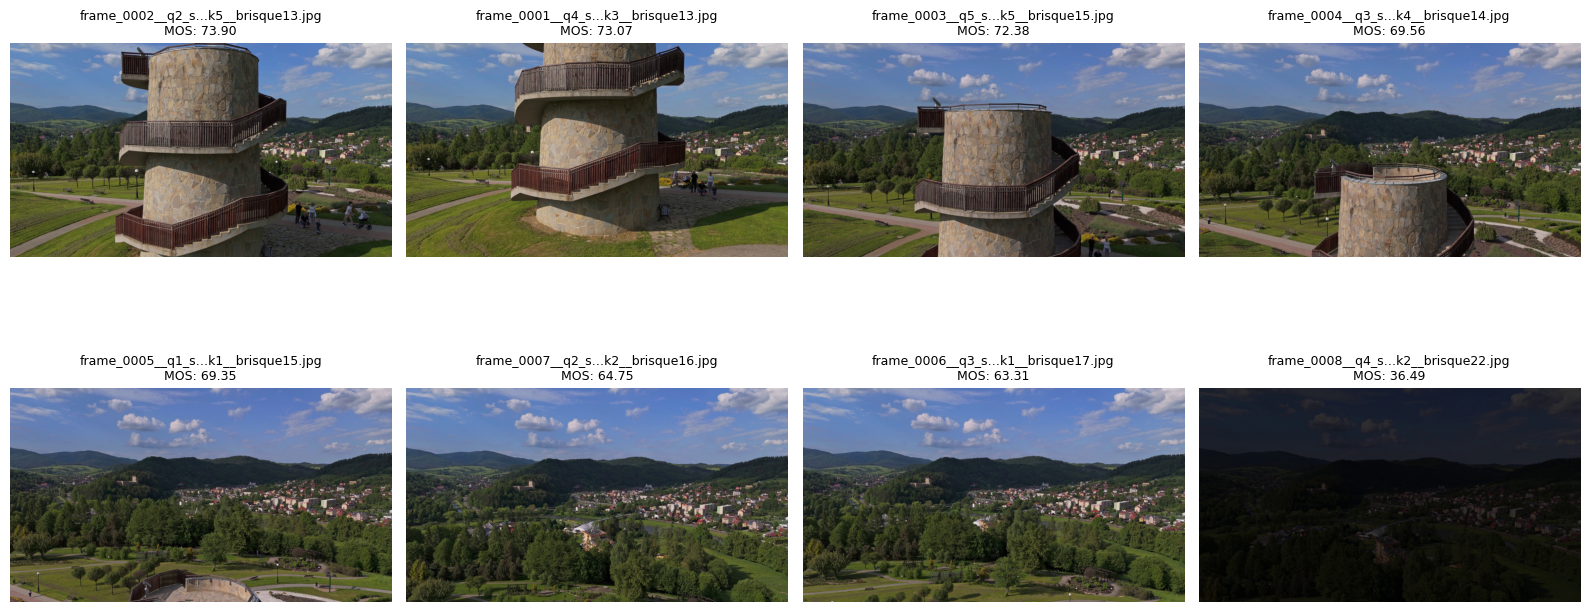

In [48]:
# === Wizualizacja: miniatury klatek z przewidywanym MOS (0–100) pod każdą ===
# Wymagane: df_preds z kolumnami ["name", "mos_pred"], FRAMES_DIR, matplotlib.pyplot jako plt, PIL.Image, Path

# Ustaw: ile kolumn w siatce (zmień, jeśli wolisz inny układ)
COLS = 4
ROWS = math.ceil(len(df_preds) / COLS)

# (opcjonalnie) wyświetl tylko TOP-N — odkomentuj poniżej:
# N = 8
# data = df_preds.head(N)
# ROWS = math.ceil(N / COLS)
# inaczej: pokazujemy wszystkie
data = df_preds

def _shorten(name: str, maxlen: int = 34) -> str:
    if len(name) <= maxlen:
        return name
    # skróć środek, by zachować początek i koniec
    keep = maxlen - 1
    left = keep // 2
    right = keep - left
    return name[:left] + "…" + name[-right:]

plt.figure(figsize=(4*COLS, 4*ROWS))
for i, row in enumerate(data.itertuples(index=False)):
    ax = plt.subplot(ROWS, COLS, i+1)
    img_path = Path(FRAMES_DIR) / row.name
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        # awaryjnie pusty obrazek, jeśli plik nie istnieje/nieczytelny
        img = Image.new("RGB", (224, 224), color=(220, 220, 220))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{_shorten(row.name)}\nMOS: {row.mos_pred:.2f}", fontsize=9)

plt.tight_layout()
plt.show()


# KONIEC KODU

In [9]:
from torch.utils.data import Dataset

IMG_SIZE = (224, 224)

# Transformacje z augmentacją
aug_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

class KonIQDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']               # pełna ścieżka do obrazu
        label = row['MOS']               # etykieta (jakość)
        
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

In [10]:
dataset = KonIQDataset(df, transform=aug_transform)
image, label = dataset[0]  # wczytanie 1. obrazu

In [11]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.6941, 0.5529, 0.0000],
          [0.2353, 0.1843, 0.1961,  ..., 0.2784, 0.4235, 0.0000],
          [0.1333, 0.1804, 0.1725,  ..., 0.0706, 0.1137, 0.0000],
          ...,
          [0.0000, 0.0510, 0.0471,  ..., 0.2667, 0.2784, 0.2588],
          [0.0000, 0.0353, 0.0471,  ..., 0.2627, 0.3765, 0.3804],
          [0.0000, 0.0392, 0.0353,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.7569, 0.5765, 0.0000],
          [0.3608, 0.2824, 0.3373,  ..., 0.3843, 0.4980, 0.0000],
          [0.2196, 0.2510, 0.3020,  ..., 0.1490, 0.1765, 0.0000],
          ...,
          [0.0000, 0.0510, 0.0627,  ..., 0.3490, 0.3569, 0.3569],
          [0.0000, 0.0392, 0.0627,  ..., 0.3333, 0.4510, 0.4667],
          [0.0000, 0.0392, 0.0510,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.7686, 0.6314, 0.0000],
          [0.4275, 0.3451, 0.4745,  ..., 0.3529, 0.5098, 0.0000],
          [0.2118, 0.2510, 0.4157,  ...,

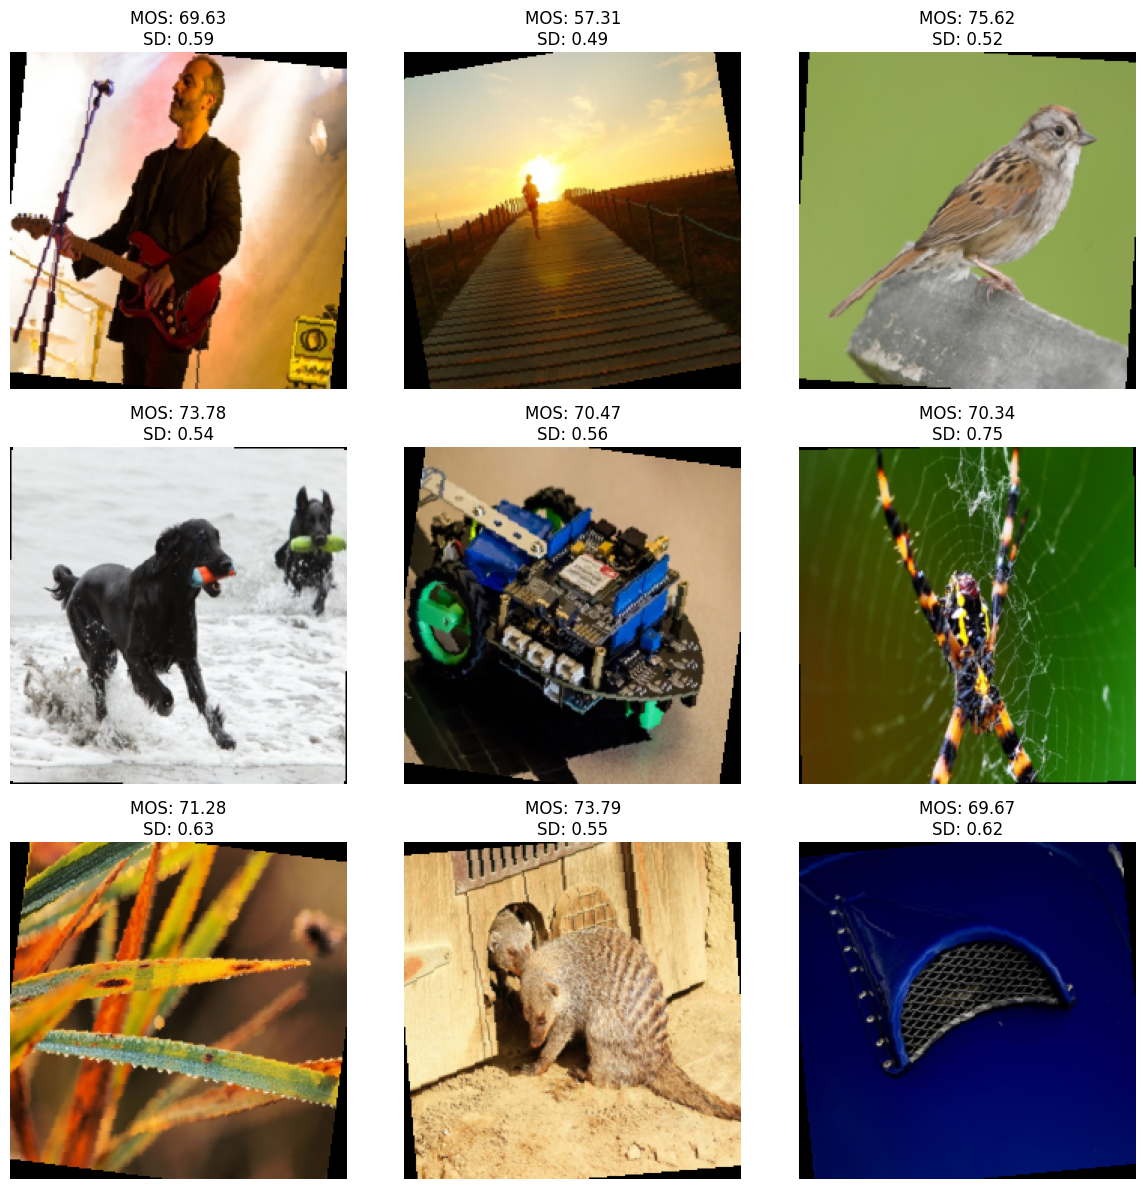

In [12]:
import random

plt.figure(figsize=(12, 12))
indices = random.sample(range(len(dataset)), 9)

for i, idx in enumerate(indices):
    image, mos = dataset[idx]
    sd = dataset.df.iloc[idx]["SD"]
    
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(image.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
    ax.set_title(f"MOS: {mos:.2f}\nSD: {sd:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

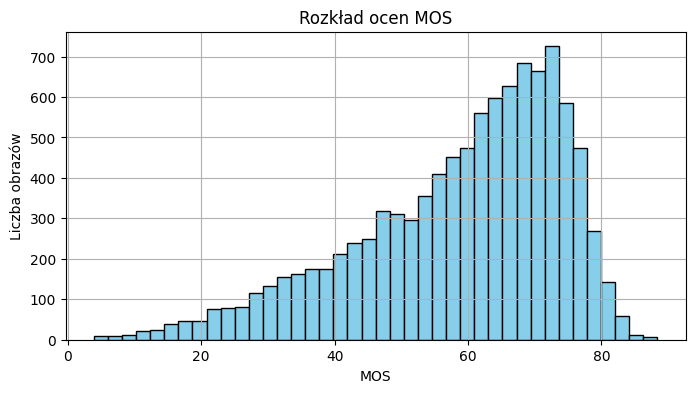

In [13]:
plt.figure(figsize=(8, 4))
df["MOS"].hist(bins=40, color="skyblue", edgecolor="black")
plt.title("Rozkład ocen MOS")
plt.xlabel("MOS")
plt.ylabel("Liczba obrazów")
plt.grid(True)
plt.show()

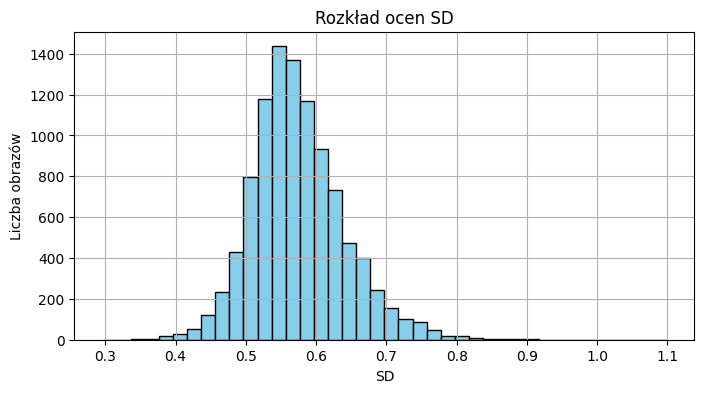

In [14]:
plt.figure(figsize=(8, 4))
df["SD"].hist(bins=40, color="skyblue", edgecolor="black")
plt.title("Rozkład ocen SD")
plt.xlabel("SD")
plt.ylabel("Liczba obrazów")
plt.grid(True)
plt.show()

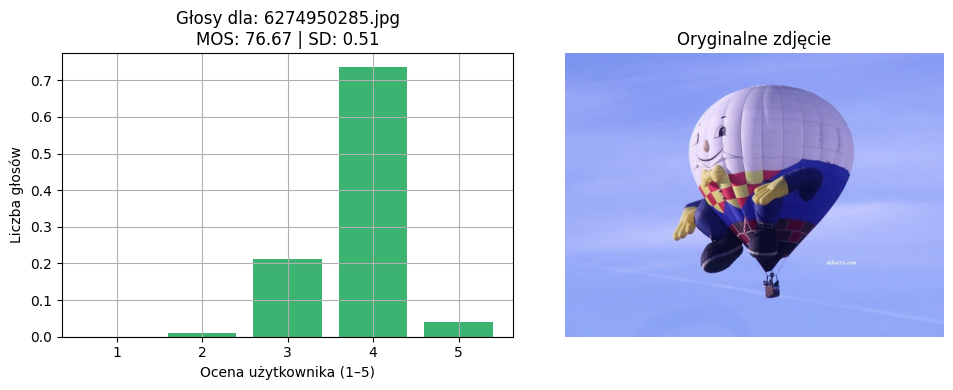

In [27]:
idx = random.randint(0, len(df) - 1)
row = df.iloc[idx]
votes = [row[f"c{i}"] for i in range(1, 6)]
img_path = row["path"]

# Wczytaj obraz w oryginalnej postaci
img = Image.open(img_path).convert("RGB")

# Tworzymy układ 1x2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# 🔹 Wykres słupkowy
ax1.bar(range(1, 6), votes, color="mediumseagreen")
ax1.set_title(f"Głosy dla: {row['image_name']}\nMOS: {row['MOS']:.2f} | SD: {row['SD']:.2f}")
ax1.set_xlabel("Ocena użytkownika (1–5)")
ax1.set_ylabel("Liczba głosów")
ax1.set_xticks(range(1, 6))
ax1.grid(True)

# 🔹 Miniaturka obrazu (oryginał)
ax2.imshow(img)
ax2.set_title("Oryginalne zdjęcie")
ax2.axis("off")

plt.tight_layout()
plt.show()

In [16]:
from torchvision.models import resnet18, ResNet18_Weights

# Załaduj model z aktualnym API
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Zamrożenie wag (opcjonalnie)
for param in model.parameters():
    param.requires_grad = False

# Podmień ostatnią warstwę na regresyjną
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

In [17]:
from torch.utils.data import DataLoader, random_split

# Parametry
batch_size = 32
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

# Podział
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoadery
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [18]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)  # trenujemy tylko ostatnią warstwę

In [ ]:
num_epochs = 10  # liczba epok
# Pętla treningowa

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        ...
